In [1]:
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('dark')

### Spotify Credientials
This is set up through Spotify's developer page

In [2]:
cid = ''      # Client ID; copy this from your app created on beta.developer.spotify.com
secret = ''   # Client Secret; copy this from your app
username = '' # Your Spotify username

#for avaliable scopes see https://developer.spotify.com/web-api/using-scopes/
scope = 'user-library-read playlist-modify-public playlist-read-private'
redirect_uri = 'http://localhost:8888/'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
token = util.prompt_for_user_token(username, scope, cid, secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

### Retrieving Audio Analysis From Spotify's API
Reads excel file with playlist information needed to extract audio analysis.

In [3]:
genres = ['techhouse', 'techno', 'trance', 'psytrance', 'trap', 'dnb', 'hardstyle']

df = pd.concat(pd.read_excel('spotify-playlists.xlsx', sheet_name=None), ignore_index=True)
df.head()

,username,playlistid,genre,title,link
0,futureofhouse,7nppx7uLgcmkZHg70HNfOk,techhouse,Tech House Top 50,https://open.spotify.com/playlist/7nppx7uLgcmk...
1,colonizemedia,5DcZdiw9a4Mc3CtLhjQmGJ,techhouse,Tech House 2020 - Best of Techno,https://open.spotify.com/playlist/5DcZdiw9a4Mc...
2,1135439236,6J1r02xyO2qkMA9dDNZytJ,techhouse,Toolroom Tech House,https://open.spotify.com/playlist/6J1r02xyO2qk...
3,128794143,4KpG3uP5U6qZTVjudIaEXD,techhouse,Tech House 2020,https://open.spotify.com/playlist/4KpG3uP5U6qZ...
4,jackrosereal,30ivbx7Xo2ZaQzMY6o6kAE,techhouse,Tech House Bangerz,https://open.spotify.com/playlist/30ivbx7Xo2Za...


In [4]:
def get_features(username, playlist_id, genre):
    results = sp.user_playlist_tracks(username, playlist_id)
    songs = results['items']
    
    while results['next']:
        results = sp.next(results)
        songs.extend(results['items'])
    
    ids = []
        
    for i in range(len(songs)):
        ids.append(songs[i]['track']['id'])
    
    ids = list(filter(None, ids))
    
    features = []
    
    for i in range(0,len(ids),50):
        audio_features = sp.audio_features(ids[i:i+50])
        
        for track in audio_features:
            features.append(track)

    features = list(filter(None, features))
    df = pd.DataFrame(features)
    df['genre'] = genre
    return df

# https://towardsdatascience.com/making-your-own-discover-weekly-f1ac7546fedb
# https://stackoverflow.com/questions/39086287/spotipy-how-to-read-more-than-100-tracks-from-a-playlist

In [5]:
def create_df(PlayLists):
    result = pd.DataFrame()
    
    # Extract songs from spotify API and append to dataframe
    for i in range(len(PlayLists)):
        df = get_features(PlayLists['username'][i], PlayLists['playlistid'][i], PlayLists['genre'][i])
        df['title'] = PlayLists['title'][i]
        result = pd.concat([result, df], ignore_index=True)
        
    # Remove Duplicates from DataFrame
    result = result.drop_duplicates()
        
    # Remove Long Duration Songs
    result = result[result.duration_ms < 1000000]
    
    # Remove low tempo songs
    result = result[result.tempo > 50]
    
    return result

In [6]:
songs = create_df(df)

In [7]:
songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,title
0,0.926,0.953,6,-5.531,0,0.0911,0.00235,0.442,0.3130,0.927,123.983,audio_features,71NOmiKvk7s5R7dUurNjuy,spotify:track:71NOmiKvk7s5R7dUurNjuy,https://api.spotify.com/v1/tracks/71NOmiKvk7s5...,https://api.spotify.com/v1/audio-analysis/71NO...,206588,4,techhouse,Tech House Top 50
1,0.704,0.989,11,-6.002,0,0.0563,0.15800,0.847,0.0747,0.849,123.972,audio_features,09GornYdyw9smCqCi5AiFK,spotify:track:09GornYdyw9smCqCi5AiFK,https://api.spotify.com/v1/tracks/09GornYdyw9s...,https://api.spotify.com/v1/audio-analysis/09Go...,179032,4,techhouse,Tech House Top 50
2,0.802,0.718,7,-9.182,1,0.0549,0.00052,0.800,0.3260,0.803,125.044,audio_features,3tiCfL7AgIOSXMrOMdBs9F,spotify:track:3tiCfL7AgIOSXMrOMdBs9F,https://api.spotify.com/v1/tracks/3tiCfL7AgIOS...,https://api.spotify.com/v1/audio-analysis/3tiC...,205440,4,techhouse,Tech House Top 50
3,0.785,0.955,6,-5.711,1,0.0425,0.01680,0.591,0.0849,0.641,123.977,audio_features,4T8VjkdqaUzF0fzweXBNEn,spotify:track:4T8VjkdqaUzF0fzweXBNEn,https://api.spotify.com/v1/tracks/4T8VjkdqaUzF...,https://api.spotify.com/v1/audio-analysis/4T8V...,200732,4,techhouse,Tech House Top 50
4,0.690,0.981,1,-6.822,1,0.0596,0.01240,0.841,0.5430,0.227,124.937,audio_features,5UJlLFhy5bF15R9f2X8N1L,spotify:track:5UJlLFhy5bF15R9f2X8N1L,https://api.spotify.com/v1/tracks/5UJlLFhy5bF1...,https://api.spotify.com/v1/audio-analysis/5UJl...,251520,4,techhouse,Tech House Top 50


### Tempo EDA
Tempo distributions for each genre

In [8]:
def graph_tempo(genre, df):
    tempo = songs.loc[songs.genre == genre, 'tempo']
    
    plt.title('Song Tempo')
    plt.hist(tempo, bins=40, range=(min(songs.tempo), 190), alpha=0.7,label=genre)
    plt.grid(b=True)
    plt.legend(loc='upper right')
    plt.xlabel('Tempo')
    plt.ylabel('Count')

In [9]:
def range_outliers(genre, df):
    tempo = songs.loc[songs.genre == genre, 'tempo']
    m = np.mean(tempo)
    sd = np.std(tempo)
    median = np.median(tempo)
    upper_bound = m + (sd*3)
    lower_bound = m - (sd*3)
    print(lower_bound, upper_bound)

In [10]:
for genre in genres:
    print(genre)
    print(songs.loc[songs.genre == genre, 'tempo'].describe())
    range_outliers(genre, songs)

techhouse
count    3557.000000
mean      124.927435
std         2.859373
min        95.075000
25%       123.995000
50%       124.995000
75%       125.999000
max       217.009000
Name: tempo, dtype: float64
116.35052057169337 133.50434926243653
techno
count    5713.000000
mean      129.699593
std         6.671139
min        79.504000
25%       126.017000
50%       128.027000
75%       131.979000
max       249.983000
Name: tempo, dtype: float64
109.68792630686829 149.71125975999678
trance
count    7023.000000
mean      134.335903
std         5.678149
min        58.619000
25%       130.000000
50%       135.999000
75%       138.004000
max       204.440000
Name: tempo, dtype: float64
117.30266967259942 151.36913724752017
psytrance
count    5773.000000
mean      143.088990
std         9.162305
min        75.049000
25%       139.979000
50%       143.027000
75%       145.995000
max       200.083000
Name: tempo, dtype: float64
115.604455697553 170.5735249017887
trap
count    10193.000000
mean  

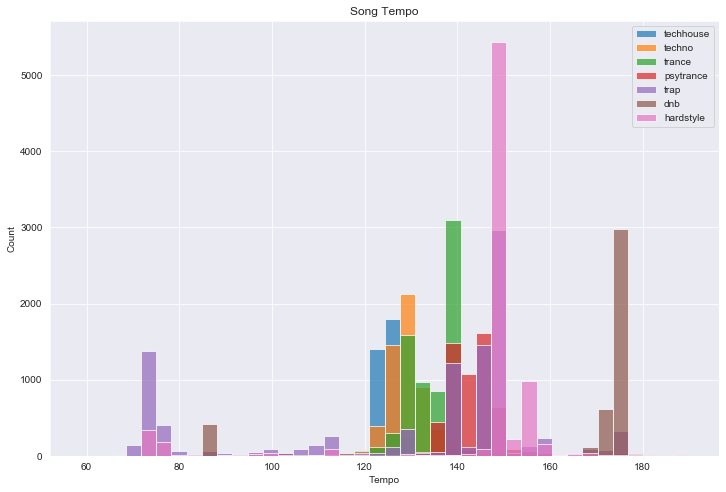

In [11]:
fig = plt.figure(figsize=(12,8))
plt.title('Song Tempo')

for genre in genres:
    graph_tempo(genre, songs)

### Chaning Half-time to Full-time tempos
For these genres, the audio analysis recorded the tempo as half of the correct tempo for some tracks. While musically not incorrect to record tempos in half-time, for consistencies sake, the tempos will be changed to all full time.

In [12]:
# Changes tempo from half time to full time given range
def chng2full_time(data, genre):
    tempo = data.loc[data.genre == genre, 'tempo']
    threshold = max(tempo)/2
    tempo[tempo < threshold] = tempo * 2
    return tempo

In [13]:
songs.loc[songs.genre == 'trap', 'tempo'] = chng2full_time(songs, 'trap')

In [14]:
songs.loc[songs.genre == 'dnb', 'tempo'] = chng2full_time(songs, 'dnb')

In [15]:
songs.loc[songs.genre == 'hardstyle', 'tempo'] = chng2full_time(songs, 'hardstyle')

### Filtering out Songs That Don't belong
One of the issues from pulling data from user made playlists is that they will add songs that are not the correct genre of the correct label. To adjust for this and have the correct ground truth I will be manually removing songs that are have too fast or slow tempo for a particular genre.

In [16]:
def filter_tempo(data, genre, max_thresh, min_thresh):
    tempo = songs.loc[songs.genre == genre, 'tempo']
    
    above_threshold = tempo[tempo > max_thresh].index.tolist()
    below_threshold = tempo[tempo < min_thresh].index.tolist()
    indexNames = above_threshold + below_threshold
    
    data.drop(indexNames, inplace=True)

In [17]:
filter_tempo(songs, 'techhouse', 135, 115)

In [18]:
filter_tempo(songs, 'techno', 150, 120)

In [19]:
filter_tempo(songs, 'trance', 155, 125)

In [20]:
filter_tempo(songs, 'psytrance', 170, 120)

In [21]:
filter_tempo(songs, 'trap', 165, 135)

In [22]:
filter_tempo(songs, 'dnb', 185, 160)

In [23]:
filter_tempo(songs, 'hardstyle', 165, 140)

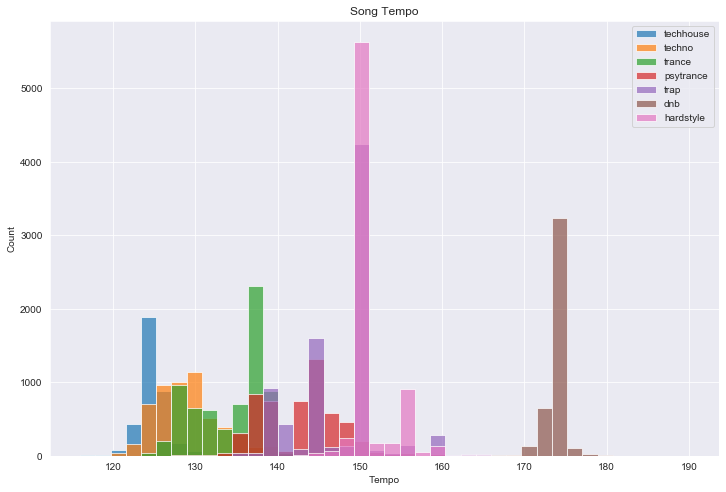

In [24]:
fig = plt.figure(figsize=(12,8))
plt.title('Song Tempo')

for genre in genres:
    graph_tempo(genre, songs)

### Sampling Songs From each genre to Generate a Balanced Dataset
Random sampling from each song distribution will create a balanced dataset for the classifier algorithms to analyze.

In [25]:
def sample_songs(df, genres, n):
    result = pd.DataFrame()
    
    for i in range(len(genres)):
        sample = songs[songs['genre'] == genres[i]].sample(n=n)
        result = pd.concat([result, sample], ignore_index=True)
    
    return result

In [26]:
songs = sample_songs(songs, genres, 3000)

In [27]:
songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,title
0,0.728,0.913,11,-6.865,0,0.0679,0.004590,0.425,0.0491,0.553,124.998,audio_features,26xW0lqwFci1qvXlaNtQOZ,spotify:track:26xW0lqwFci1qvXlaNtQOZ,https://api.spotify.com/v1/tracks/26xW0lqwFci1...,https://api.spotify.com/v1/audio-analysis/26xW...,233453,4,techhouse,Tech House 2020
1,0.709,0.969,0,-3.665,0,0.0967,0.000508,0.647,0.0292,0.894,125.037,audio_features,2k11CoTdPRyYpNKjdOXBr6,spotify:track:2k11CoTdPRyYpNKjdOXBr6,https://api.spotify.com/v1/tracks/2k11CoTdPRyY...,https://api.spotify.com/v1/audio-analysis/2k11...,341760,4,techhouse,Tech House Top 50
2,0.736,0.979,7,-3.790,1,0.0582,0.000365,0.878,0.0337,0.878,125.021,audio_features,6joAxSuf0LJmmePThLldME,spotify:track:6joAxSuf0LJmmePThLldME,https://api.spotify.com/v1/tracks/6joAxSuf0LJm...,https://api.spotify.com/v1/audio-analysis/6joA...,338563,4,techhouse,Beatoirt Best New Tech House
3,0.772,0.974,0,-4.444,1,0.0677,0.021400,0.873,0.0901,0.961,126.005,audio_features,1qo1dnwguBAbiqRNd3oTEi,spotify:track:1qo1dnwguBAbiqRNd3oTEi,https://api.spotify.com/v1/tracks/1qo1dnwguBAb...,https://api.spotify.com/v1/audio-analysis/1qo1...,196190,4,techhouse,Tech House Elrow Secrets
4,0.802,0.938,6,-6.258,1,0.0538,0.002610,0.595,0.0745,0.932,125.987,audio_features,2nsrP4TCSECbIwY5g7Ym9f,spotify:track:2nsrP4TCSECbIwY5g7Ym9f,https://api.spotify.com/v1/tracks/2nsrP4TCSECb...,https://api.spotify.com/v1/audio-analysis/2nsr...,384762,4,techhouse,Tech House Essentials by Distortion


In [28]:
# songs.to_csv(r'.\edm_songs.csv')